In [1]:
! pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 690 kB 4.0 MB/s 
     |████████████████████████████████| 38.1 MB 48.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
! pip install bootstrapped

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bootstrapped: filename=bootstrapped-0.0.2-py2.py3-none-any.whl size=13954 sha256=3e52957458e38bc76bb63c5b006dda1e149e25969d248764aa9a2bae38cd7725
  Stored in directory: /root/.cache/pip/wheels/15/55/6a/9a722f067ac4c3dfab359ed2ec7906b9cc6649156d9886bd59
Successfully built bootstrapped


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy
import statsmodels.api as sm
import statsmodels.stats.proportion as proportion
import math
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare
import phik
from copy import deepcopy
import itertools
import collections
from copy import deepcopy
import random as rn

# **Чтение и изучение данных**

In [5]:
df = pd.read_csv('/content/apartment.csv')
df.head()

,City,Price range per sqft,Avg price per sqft,Price rise
0,Ahmedabad,"611 - 1,71,969 / sqft","35,178.07 / sqft",84.3%
1,Bangalore,"656 - 1,40,148 / sqft","76,956.86 / sqft",90.1%
2,Chennai,"667 - 55,859 / sqft","32,297.07 / sqft",64.8%
3,Delhi,"741 - 1,89,032 / sqft","58,231.75 / sqft",64.5%
4,Ghaziabad,"634 - 84,986 / sqft","29,583.89 / sqft",43.4%


In [8]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [9]:
df.axes

[RangeIndex(start=0, stop=451, step=1),
 Index(['city', 'price_range_per_sqft', 'avg_price_per_sqft', 'price_rise'], dtype='object')]

In [10]:
df.dtypes

city                    object
price_range_per_sqft    object
avg_price_per_sqft      object
price_rise              object
dtype: object

In [11]:
length = df.shape[0]
size = df.size

In [13]:
df.memory_usage()[:3]

Index                    128
city                    3608
price_range_per_sqft    3608
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   city                  451 non-null    object
 1   price_range_per_sqft  451 non-null    object
 2   avg_price_per_sqft    451 non-null    object
 3   price_rise            451 non-null    object
dtypes: object(4)
memory usage: 14.2+ KB


# ***Предобработка данных - изучение***

In [15]:
def custom_hist(df : pd.Series):
  fig = plt.figure(figsize = (7, 7))
  ax = fig.add_subplot()
  plt.hist(df, color = 'orange', edgecolor = 'blue', density = True, bins = 20, label = 'hist')
  plt.axvline(np.mean(df), linestyle = 'dashed', color = 'red', linewidth = 2, label = 'average')
  plt.axvline(np.quantile(df, 0.25), linestyle = 'dashed', color = 'blue', linewidth = 2, label = '0.25Quantile')
  plt.axvline(np.quantile(df, 0.75), linestyle = 'dashed', color = 'blue', linewidth = 2, label = '0.75Quantile')
  plt.title('Histogram')
  plt.xlabel('Values')
  plt.ylabel('Counter of values')
  plt.xticks(rotation = 45)
  plt.minorticks_on()
  plt.grid(which = 'minor', ls = '--', linewidth = 0.3)
  plt.grid(which = 'major', ls = ':', linewidth = 0.2)
  plt.show();

def describe_columns(df : pd.Series):
  print(f'Counter of nans : {df.isna().mean()}')
  print(f'Dtype : {df.dtypes}')
  print(f'Couter of unique elements {len(frozenset(list(df)))}')
  print(f'Is empty ? {df.empty}')

In [16]:
df.head()

,city,price_range_per_sqft,avg_price_per_sqft,price_rise
0,Ahmedabad,"611 - 1,71,969 / sqft","35,178.07 / sqft",84.3%
1,Bangalore,"656 - 1,40,148 / sqft","76,956.86 / sqft",90.1%
2,Chennai,"667 - 55,859 / sqft","32,297.07 / sqft",64.8%
3,Delhi,"741 - 1,89,032 / sqft","58,231.75 / sqft",64.5%
4,Ghaziabad,"634 - 84,986 / sqft","29,583.89 / sqft",43.4%


In [17]:
# city

In [35]:
describe_columns(df['city'])

Counter of nans : 0.0
Dtype : object
Couter of unique elements 215
Is empty ? False


In [36]:
df.groupby('city')['price_rise'].agg(['count']).sort_values('count', ascending = False).reset_index()

,city,count
0,Agartala,1
1,Nagaur,1
2,Nainital,1
3,Nalgonda,1
4,Nanded,1
...,...,...
210,Gwalior,1
211,Haridwar,1
212,Hathras,1
213,Hazaribagh,1


In [37]:
# price_range_per_sqft

In [27]:
df = df.loc[df['price_range_per_sqft'] != '-']

In [30]:
df['range'] = df['price_range_per_sqft'].transform(lambda x: x.split()[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
df['range'] = df['range'].str.replace(',', '')
df['range'] = df['range'].astype('int32')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
df.head()

,city,price_range_per_sqft,avg_price_per_sqft,price_rise,range
0,Ahmedabad,"611 - 1,71,969 / sqft","35,178.07 / sqft",84.3%,611
1,Bangalore,"656 - 1,40,148 / sqft","76,956.86 / sqft",90.1%,656
2,Chennai,"667 - 55,859 / sqft","32,297.07 / sqft",64.8%,667
3,Delhi,"741 - 1,89,032 / sqft","58,231.75 / sqft",64.5%,741
4,Ghaziabad,"634 - 84,986 / sqft","29,583.89 / sqft",43.4%,634


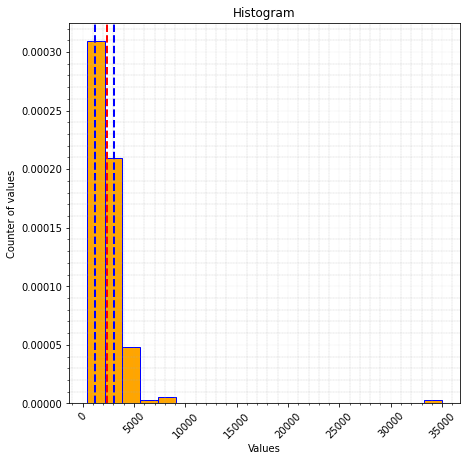

In [38]:
custom_hist(df['range'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


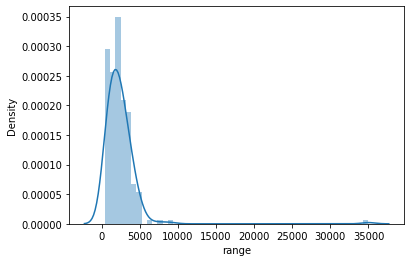

In [39]:
sns.distplot(df['range'])

In [41]:
df['range'].describe()

count      215.000000
mean      2416.837209
std       2597.428357
min        417.000000
25%       1221.000000
50%       2060.000000
75%       3026.500000
max      35000.000000
Name: range, dtype: float64

In [43]:
df.head()

,city,price_range_per_sqft,avg_price_per_sqft,price_rise,range
0,Ahmedabad,"611 - 1,71,969 / sqft","35,178.07 / sqft",84.3%,611
1,Bangalore,"656 - 1,40,148 / sqft","76,956.86 / sqft",90.1%,656
2,Chennai,"667 - 55,859 / sqft","32,297.07 / sqft",64.8%,667
3,Delhi,"741 - 1,89,032 / sqft","58,231.75 / sqft",64.5%,741
4,Ghaziabad,"634 - 84,986 / sqft","29,583.89 / sqft",43.4%,634


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


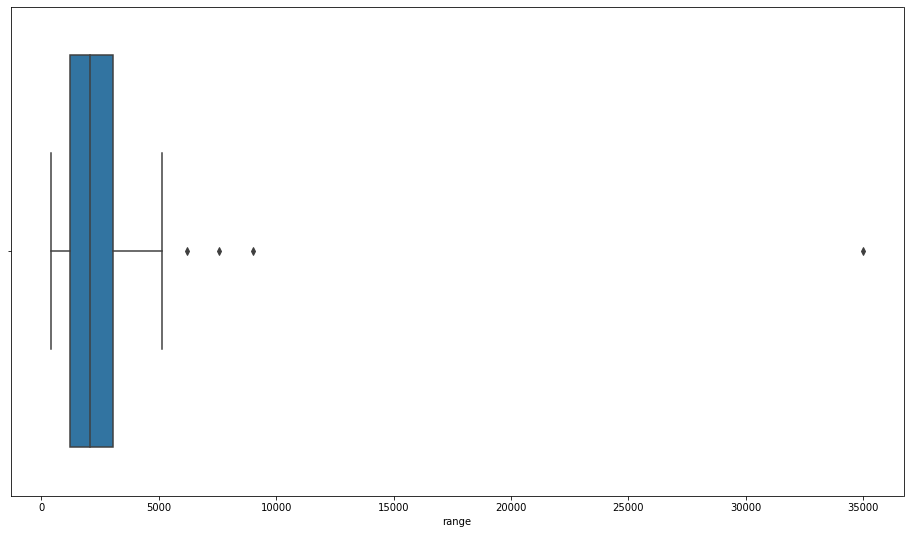

In [46]:
plt.figure(figsize = (16, 9))
sns.boxplot(df['range']);

In [57]:
df = df.loc[df['range'].between(10, np.quantile(df['range'], 0.99))]

In [59]:
df.dtypes

city                    object
price_range_per_sqft    object
avg_price_per_sqft      object
price_rise              object
range                    int32
dtype: object

In [60]:
df['range'].describe()

count     209.000000
mean     2160.784689
std      1137.884984
min       417.000000
25%      1197.000000
50%      2013.000000
75%      2933.000000
max      5000.000000
Name: range, dtype: float64

In [61]:
def categorize_range(range : int):
  if range >= 417 and range <= 1197:
    return 50
  elif range >= 1197 and range <= 2013:
    return 60
  elif range >=2013 and range <= 2933:
    return 70
  else:
    return 80

In [62]:
df['intervals_range_per_sqft'] = df['range'].apply(lambda x: categorize_range(x))

In [63]:
df.head()

,city,price_range_per_sqft,avg_price_per_sqft,price_rise,range,intervals_range_per_sqft
0,Ahmedabad,"611 - 1,71,969 / sqft","35,178.07 / sqft",84.3%,611,50
1,Bangalore,"656 - 1,40,148 / sqft","76,956.86 / sqft",90.1%,656,50
2,Chennai,"667 - 55,859 / sqft","32,297.07 / sqft",64.8%,667,50
3,Delhi,"741 - 1,89,032 / sqft","58,231.75 / sqft",64.5%,741,50
4,Ghaziabad,"634 - 84,986 / sqft","29,583.89 / sqft",43.4%,634,50


In [64]:
df['dev_sqft'] = df['price_range_per_sqft'].transform(lambda x: x.split()[2])

In [68]:
df = df.loc[df['dev_sqft'] != 'sqft']

In [83]:
df.head()

,city,price_range_per_sqft,avg_price_per_sqft,price_rise,range,intervals_range_per_sqft,dev_sqft,result_range
0,Ahmedabad,"611 - 1,71,969 / sqft","35,178.07 / sqft",84.3,611,50,171969,2828.38
1,Bangalore,"656 - 1,40,148 / sqft","76,956.86 / sqft",90.1,656,50,140148,2146.96
2,Chennai,"667 - 55,859 / sqft","32,297.07 / sqft",64.8,667,50,55859,450.18
3,Delhi,"741 - 1,89,032 / sqft","58,231.75 / sqft",64.5,741,50,189032,3039.64
4,Ghaziabad,"634 - 84,986 / sqft","29,583.89 / sqft",43.4,634,50,84986,1065.72


In [79]:
#df['dev_sqft'] = df['dev_sqft'].str.replace(',','').str.replace(',','')
df['dev_sqft'] = df['dev_sqft'].astype('int64')

In [73]:
df.dtypes

city                        object
price_range_per_sqft        object
avg_price_per_sqft          object
price_rise                  object
range                        int32
intervals_range_per_sqft     int64
dev_sqft                     int64
dtype: object

In [75]:
df['result_range'] = abs(df['dev_sqft'] / df['intervals_range_per_sqft'] - df['range'])

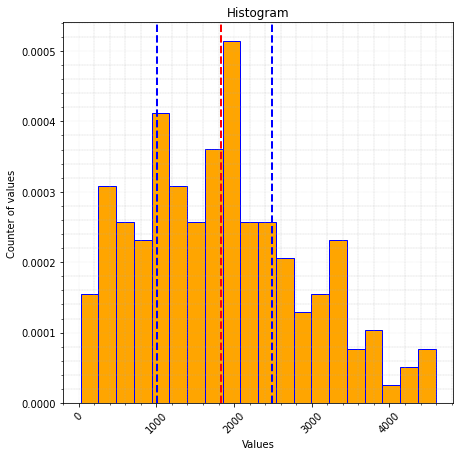

In [76]:
custom_hist(df['result_range'])

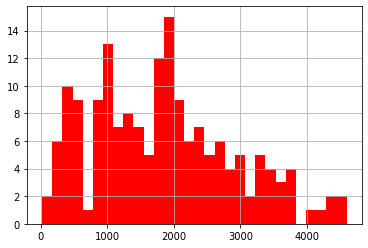

In [78]:
df['result_range'].hist(bins = 30, color = 'red')

In [82]:
df['price_rise'] = df['price_rise'].str.replace('%', '')
df['price_rise']= df['price_rise'].astype('float64')

In [81]:
df = df.loc[df['price_rise'] != '-']

# **Проверка гипотез**

**При распределении на интервалы - средний покажет лучшее среднее по price_rise чем наивысший интервал**

In [84]:
df['intervals'] = pd.qcut(df['result_range'], 4, labels = ['low', 'med', 'high', 'very_high'])

In [86]:
df.groupby('intervals')['range'].agg(['count']).sort_values('count', ascending = False).reset_index()

,intervals,count
0,low,32
1,med,32
2,very_high,32
3,high,31


In [87]:
med = df.loc[df['intervals'] == 'med']
high = df.loc[df['intervals'] == 'very_high']

**Выборки между собой равны - смотри на распределения и эквивалентность дисперсий**

In [89]:
def two_histograms(df1 : pd.Series, df2 : pd.Series):
  fig = plt.figure(figsize = (16, 9))
  ax = fig.add_subplot()
  plt.hist(df1, color = 'orange', edgecolor = 'black', bins = 20, label = 'first DF')
  plt.hist(df2, color = 'blue', edgecolor = 'red', bins = 20, label = 'second DF', alpha = 0.4)
  plt.axvline(df1.mean(), color = 'red', linewidth = 2, linestyle = 'dashed', label = 'average Df1')
  plt.axvline(df2.mean(), color = 'red', linewidth = 2, linestyle = 'dashed', label = 'average Df2')
  plt.title('Two histograms')
  plt.xlabel('Values of hisograms')
  plt.ylabel('Counter of values')
  plt.grid()
  plt.show();

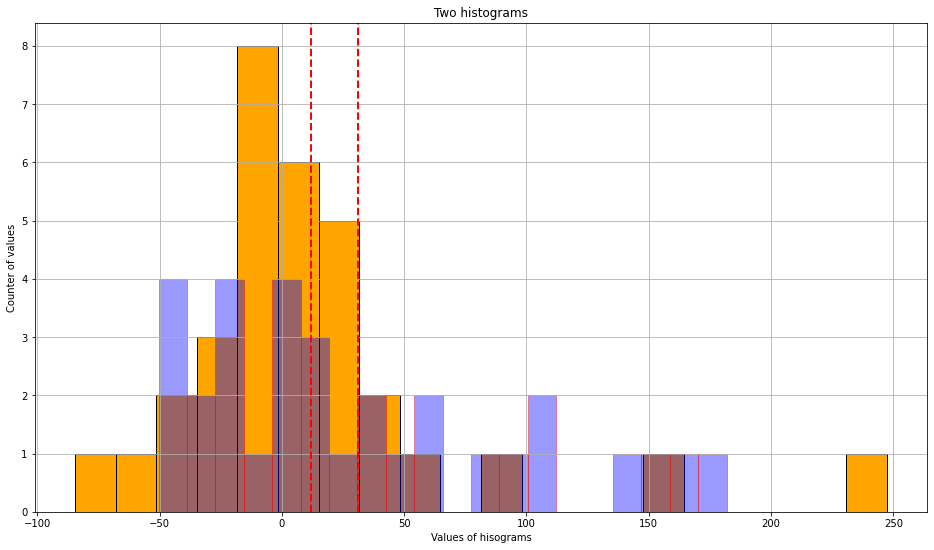

In [91]:
two_histograms(med['price_rise'], high['price_rise'])

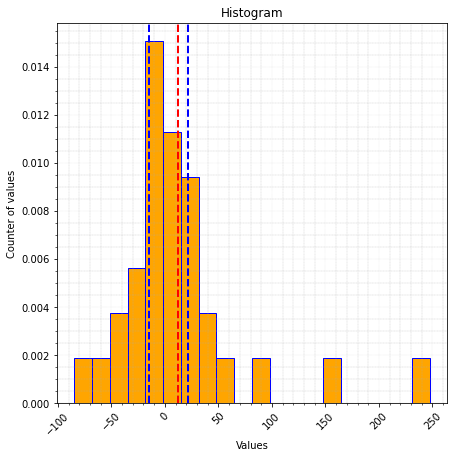

In [93]:
custom_hist(med['price_rise']) # Если убрать выбросы то почти нормальное распределение

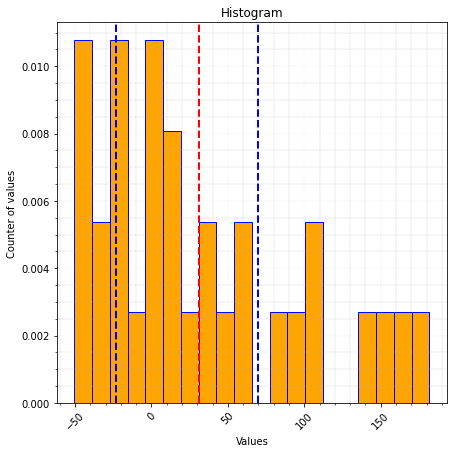

In [95]:
custom_hist(high['price_rise']) # Унимодальное распрделение - ттест точно не подойдет

In [96]:
table, pvalue = scipy.stats.shapiro(med['price_rise'])

print(f'Pvalue is {pvalue}')

if pvalue >= 0.01:
  print('Normalize')
else:
  print('Unimodalno')

Pvalue is 2.2590535081690177e-05
Unimodalno


In [97]:
table, pvalue = scipy.stats.shapiro(high['price_rise'])

print(f'Pvalue is {pvalue}')

if pvalue >= 0.01:
  print('Normalize')
else:
  print('Unimodalno')

Pvalue is 0.009717815555632114
Unimodalno


In [98]:
# Проверка эквивалетности дисперсий

In [104]:
def generate_bootstrap_mean(first_col : pd.Series, second_col : pd.Series):
 
  length_first_col = first_col.shape[0]
  length_second_col = second_col.shape[0]
  first_col = list(first_col)
  second_col = list(second_col)
  result_stack = []
  for _ in range(10 ** 4):
    stack = []
    for _ in range(length_first_col // 2):
      random = rn.randint(0, length_first_col - 1)
      stack += [first_col[random]]
    
    stack = pd.Series(stack)
    result_stack += [np.var(stack)]
 
  second_result = []
  for _ in range(10 ** 4):
    stack = []
    for _ in range(length_second_col // 2):
      random = rn.randint(0, length_second_col - 1)
      stack += [second_col[random]]
    
    stack = pd.Series(stack)
    second_result += [np.var(stack)]
  return pd.Series(result_stack) - pd.Series(second_result)

In [105]:
arr = generate_bootstrap_mean(med['price_rise'], high['price_rise'])

In [106]:
left = np.mean(arr) - 2 * np.std(arr)
right = np.mean(arr) + 2 * np.std(arr)

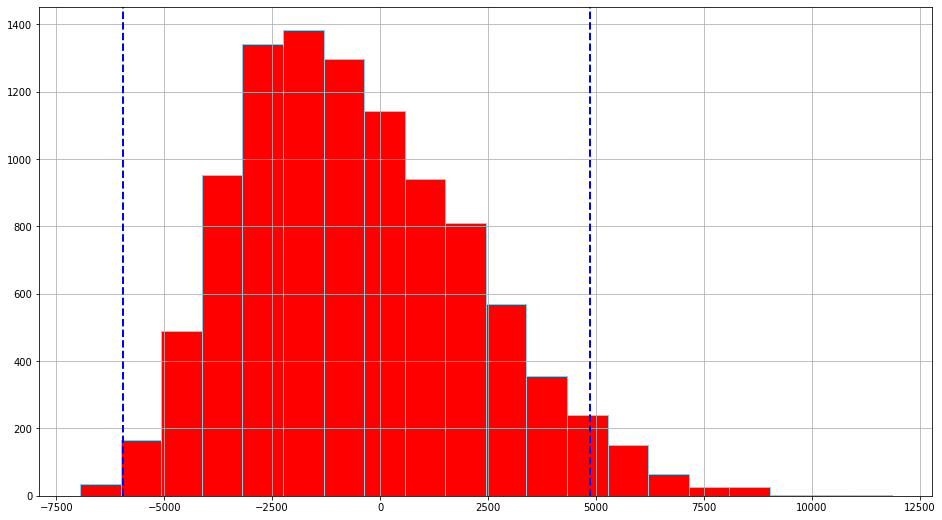

In [108]:
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot()
plt.hist(arr,  color = 'red', edgecolor = 'skyblue', bins = 20)
plt.axvline(left, linestyle = 'dashed', color = 'blue', linewidth = 2)
plt.axvline(right, linestyle = 'dashed', color = 'blue', linewidth = 2)
plt.grid()
plt.show();  # Дисперсии почти идеально эквивалентны

In [ ]:
# Проверка с помощью тестов

In [111]:
statistics, pvalue = scipy.stats.fligner(med['price_rise'], high['price_rise'])

print(f'Pvalue is {pvalue}')

if pvalue >= 0.01:
  print('Equal vars')
else:
  print('None equal vars')

Pvalue is 0.0793237999241433
Equal vars


In [112]:
# Выбор теста - мановитней вполне подойдет - либо же можно учесть еще и бутстрап

In [114]:
statistics, pvalue = scipy.stats.mannwhitneyu(med['price_rise'], high['price_rise'])

print(f'Pvalue is {pvalue}')

if pvalue >= 0.01:
  print('Нет причин отвергать нулевию гипотезу')
else:
  print('Отвергаем нулевую гипотезу')

Pvalue is 0.25372000093785496
Нет причин отвергать нулевию гипотезу
